## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.


## 1. Exploratory Data Analysis

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, I have not used 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [4]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [5]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [6]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

pheww. No missing values.

In [5]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

This implies that there is no inconsistency in data wrt the drop location and trip duration

In [7]:
np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) >1

array([False, False, False, ..., False, False, False])

In [8]:
df['trip_duration'].describe()/3600 # Trip duration in hours

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

Presence of an outlier : max is too high than the rest

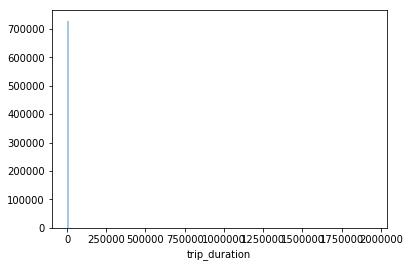

In [10]:
sns.distplot(df['trip_duration'], kde = False, bins = 200)
plt.show()

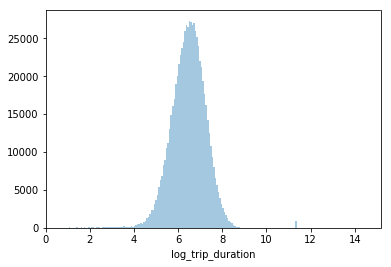

In [11]:
#need to aply log transformation
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

In [12]:
df[df['trip_duration']/3600 > 500]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,log_trip_duration
21813,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.78965,40.643559,-73.95681,40.773087,0,1939736,1939736.0,14.478063


In [14]:
#Let us remove this

df = df.drop(21813,axis=0)

In [15]:
df[df['trip_duration']/3600 > 500] #not present anymore

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,log_trip_duration


Text(0, 0.5, 'Frequency')

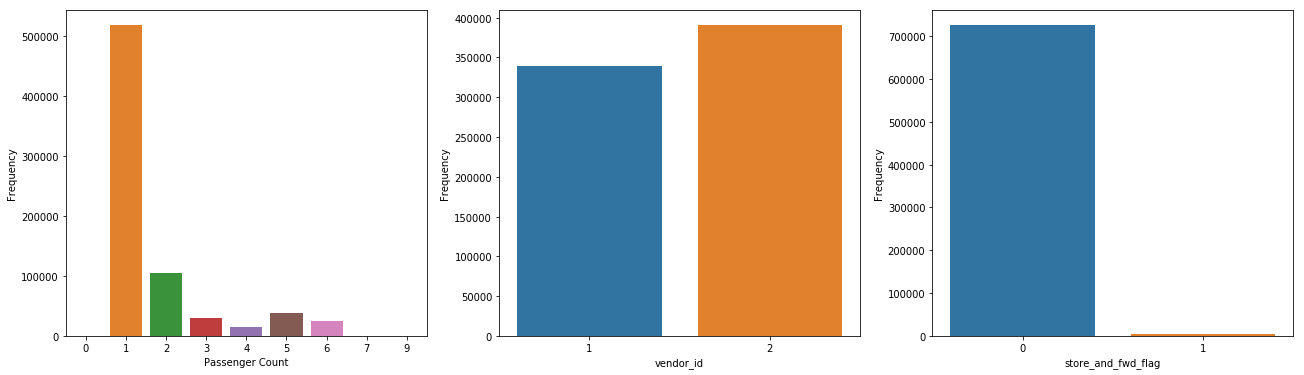

In [19]:
#Univariate Visualization

# Binary Features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')


1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1
3. The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

In [20]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

Clearly, These trips are for first 6 months of 2016. To look at trends, we first need to extract week days and hour of day from the pickup date.

In [21]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

Text(0, 0.5, 'Total number of pickups')

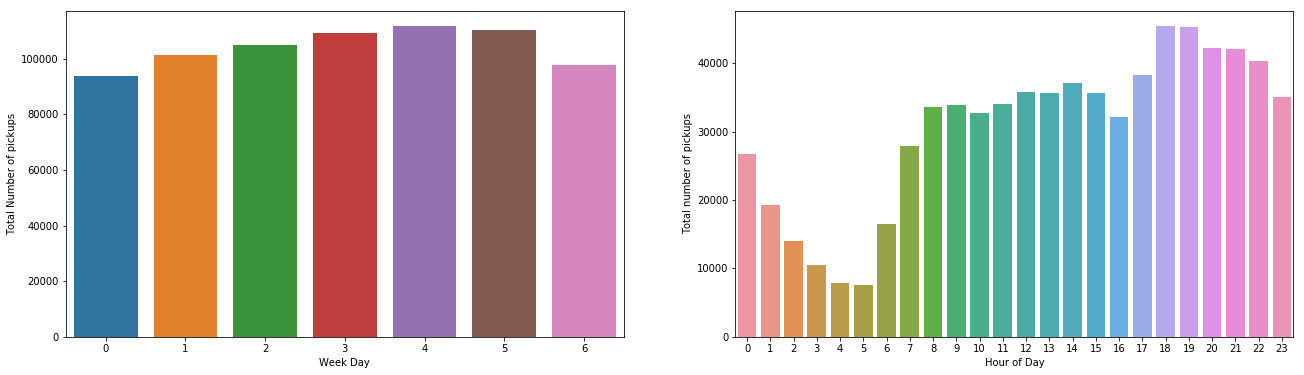

In [22]:
# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(df['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

# vendor_id
plt.subplot(122)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')


* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

In [23]:
#Lets look at the geospatial or location features to check consistency. 
#They should not vary much as we are only considering trips within New York city.

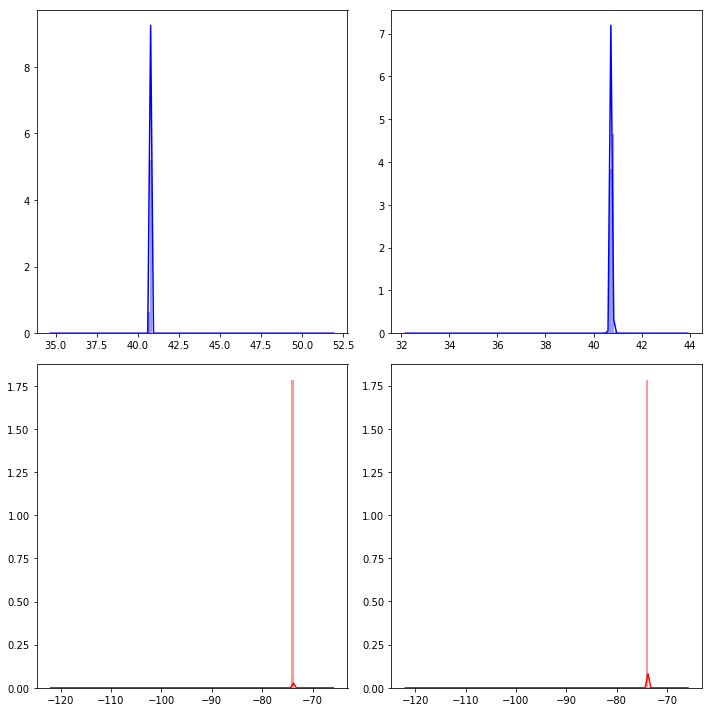

In [26]:
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

Text(0, 0.5, 'drop lattitude')

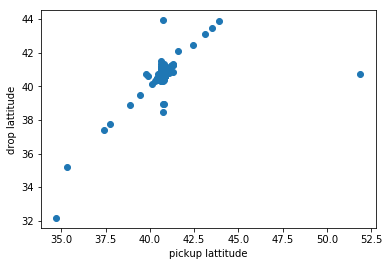

In [28]:
plt.scatter(df['pickup_latitude'],df['dropoff_latitude'])
plt.xlabel('pickup lattitude')
plt.ylabel('drop lattitude')

Text(0, 0.5, 'drop long')

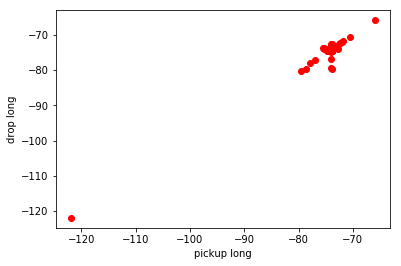

In [34]:
plt.scatter(df['pickup_longitude'],df['dropoff_longitude'],color ='r')
plt.xlabel('pickup long')
plt.ylabel('drop long')

So, in order to understand the distribution we need to look closer to the dense cluster (remove outliers)

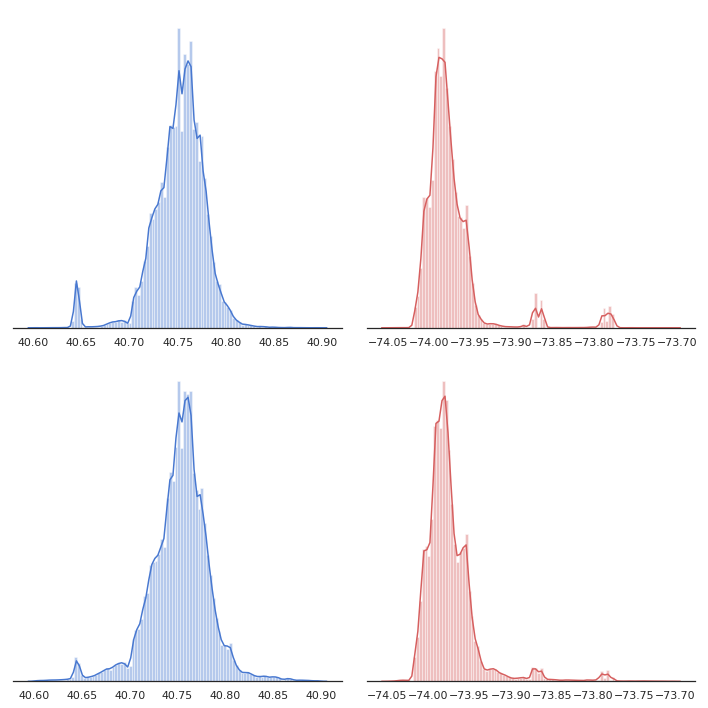

In [90]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms


For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

In [91]:
df.groupby('day_of_week')[['trip_duration']].mean().unstack()

               day_of_week
trip_duration  0              887.424028
               1              956.223061
               2              970.948849
               3              999.529268
               4              983.842079
               5              908.726033
               6              887.845323
dtype: float64

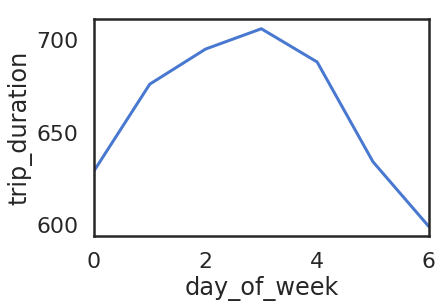

In [92]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", value="trip_duration") #tsplot 

In [93]:
summary_wdays_avg_duration

,day_of_week,trip_duration,unit
0,0,629,1
1,1,676,1
2,2,695,1
3,3,706,1
4,4,688,1
5,5,634,1
6,6,599,1


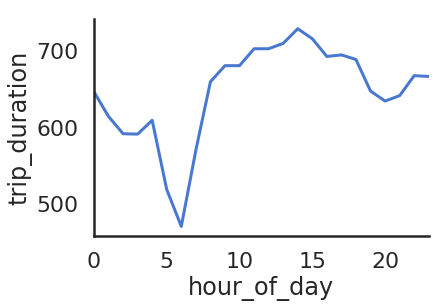

In [94]:
summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_hourly_avg_duration, time="hour_of_day", unit = "unit", value="trip_duration")
sns.despine(bottom = False)



* Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

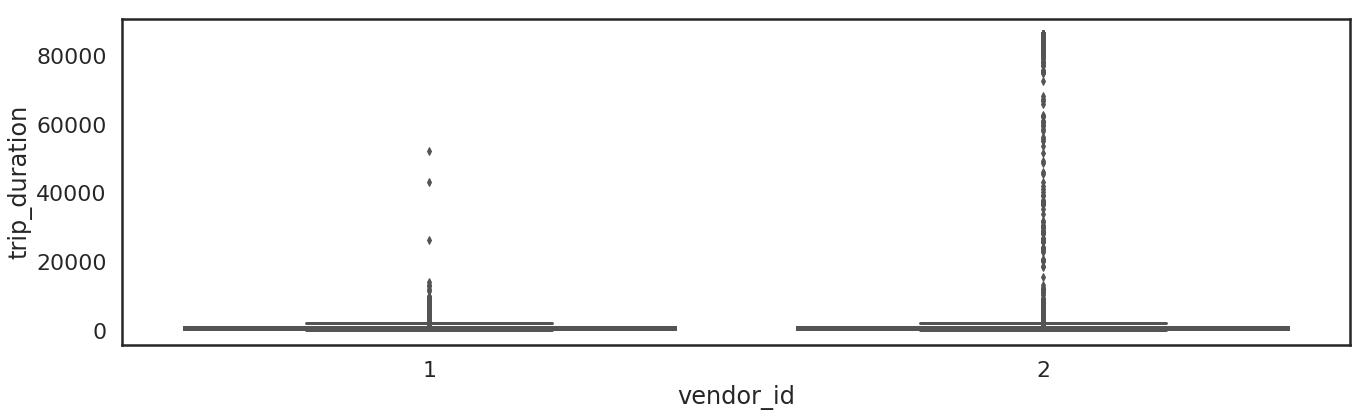

In [95]:
plt.figure(figsize=(22, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=df)
plt.show()

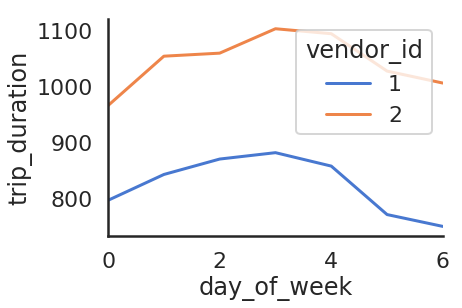

In [96]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False) #just to remove the borders


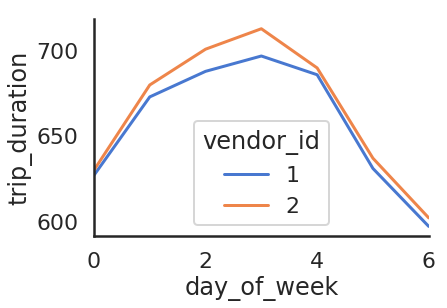

In [97]:
#median values

summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)



In [98]:
df.passenger_count.value_counts()

1    515242
2    104576
5     38776
3     29561
6     24035
4     13972
0        31
9         1
Name: passenger_count, dtype: int64

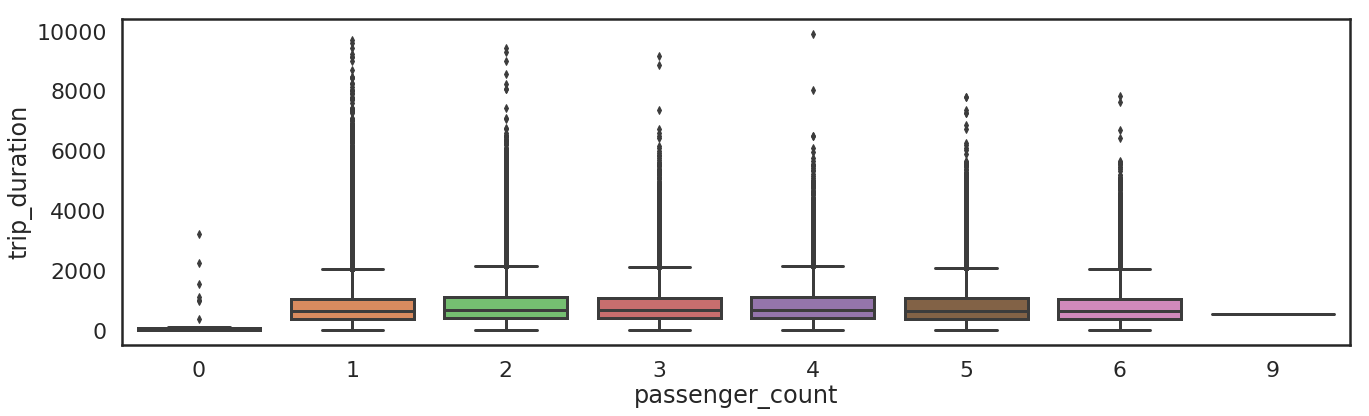

In [99]:
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()

* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

In [100]:
### Visualise most frequently occuring Pickup points on the lattitude-longitude Map

df['dropoff_longitude'].max(), df['dropoff_longitude'].min()

(-73.70093536376955, -74.04988861083984)

In [101]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration',
       'day_of_week', 'hour_of_day'],
      dtype='object')

In [86]:
#pick up longitude list 
pl = list(map(float , pd.DataFrame(df.groupby(['pickup_longitude'])['id'].count()).index))

In [88]:
#pick up lattitude list
pla = list(map(float , pd.DataFrame(df.groupby(['pickup_latitude'])['id'].count()).index))

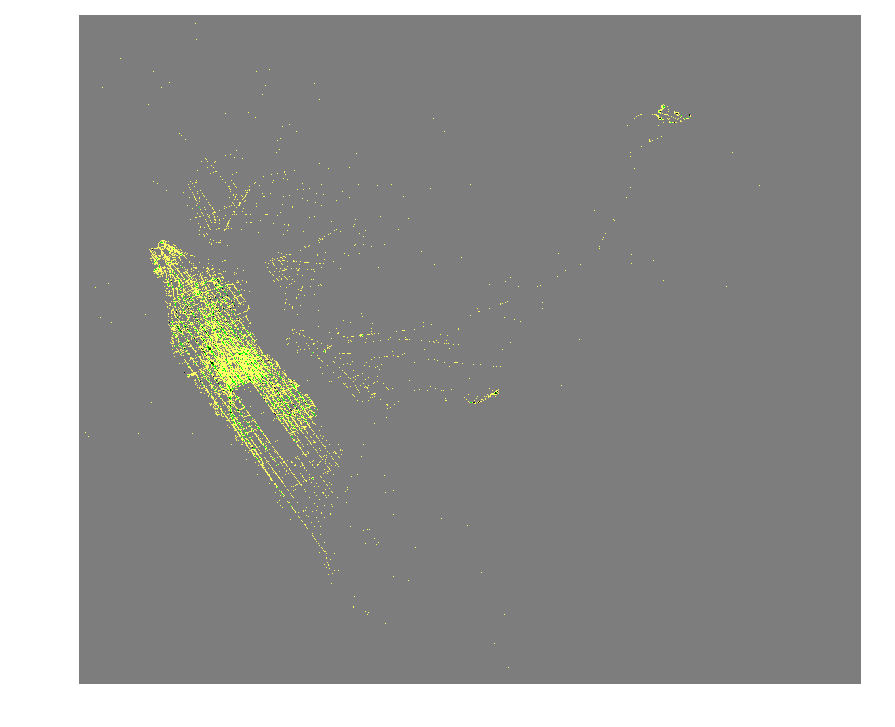

In [106]:

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 125
rgb[..., 1] = 125
rgb[..., 2] = 125
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0: #if the frequency is more than 25, then a black point
            rgb[i][j][0] = 0
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0: #if the frequency is more than 10, then a blue point
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else: #else  point
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 102
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

In [108]:
pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

id
pick_lat_new pick_lon_new    
2            544            1
6            840            1
8            454            1
9            706            1
17           1030           1
19           637            1
23           467            1
28           1135           1
             2998           1
35           831            1
             884            1
37           776            1
41           777            1
42           521            1
43           767            1
54           2832           1
106          1308           1
108          965            1
114          510            1
             525            1
116          152            1
118          819            1
127          151            1
136          961            1
140          1053           1
144          789            1
161          1155           1
162          745            1
             751            1
             752            1
...                        ..
2819         223            1
2823         411            1
             1476           1
2826         1574           1
2829         1688           1
2836         1343           1
2851         1520           1
2853         1416           1
2861         2019           1
2875         1556           1
2880         1896           1
             2215           1
2881         1898           1
2890         1419           1
2899         1516           1
2917         1927           1
2924         1494           1
2926         1922           1
2929         1505           1
2938         753            1
2942         1929           1
2943         1895           1
2953         1985           1
2957         1526           1
2960         352            1
2961         1872           1
2963         1654           1
2964         1780           1
2967         1794           1
2994         2501           1

[163591 rows x 1 columns]

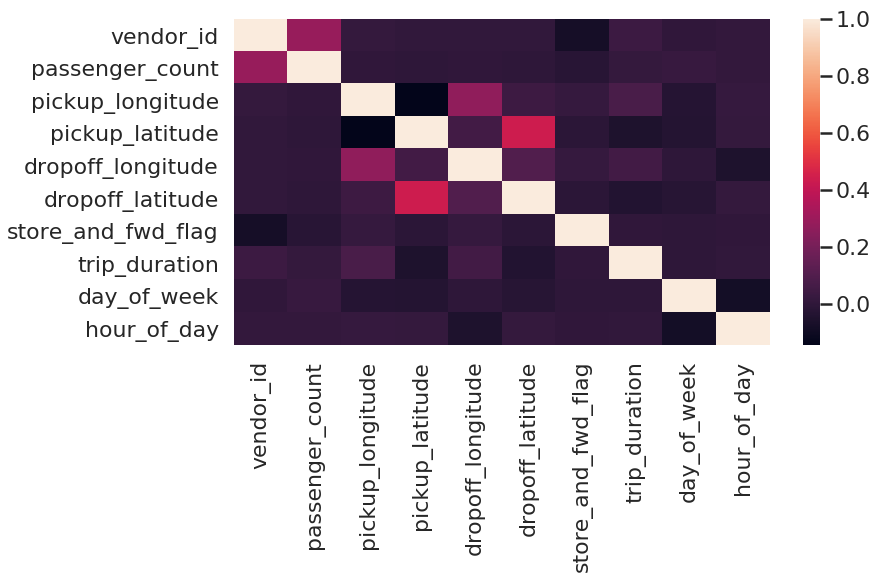

In [115]:
plt.figure(figsize=(12, 6))

df1 = df.drop(['id', 'pickup_datetime', 'dropoff_datetime','check_trip_duration','log_trip_duration'],axis=1)
sns.heatmap(df1.corr())

In [116]:
#From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.